In [12]:
%config IPCompleter.greedy=True
%matplotlib inline

import csv, json, os, sys
import requests
from time import sleep

import obspy
from obspy import read

from obspy.core.event import read_events
from obspy import read_inventory

from obspy.core import UTCDateTime

DATA_PATH = os.path.expanduser('~/.seisml/mars/')

In [14]:
path = '/home/b/.seisml/mars/raw/XB-ELYSE-02-2019-02-12T02:43:01.313000-2019-02-12T04:14:37.259000.mseed'
st = read(path)
st[0].stats
tr1 = st[0].slice(UTCDateTime("2019-02-12T02:43:02"), UTCDateTime("2019-02-12T02:43:10"))
tr2 = st[1].slice(UTCDateTime("2019-02-12T02:43:02"), UTCDateTime("2019-02-12T02:43:10"))
tr3 = st[2].slice(UTCDateTime("2019-02-12T02:43:02"), UTCDateTime("2019-02-12T02:43:10"))

obspy.core.Stream([tr1, tr2, tr3])

3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-02-12T02:43:02.013000Z - 2019-02-12T02:43:10.013000Z | 20.0 Hz, 161 samples
XB.ELYSE.02.BHV | 2019-02-12T02:43:02.013000Z - 2019-02-12T02:43:10.013000Z | 20.0 Hz, 161 samples
XB.ELYSE.02.BHW | 2019-02-12T02:43:02.013000Z - 2019-02-12T02:43:10.013000Z | 20.0 Hz, 161 samples

In [10]:
st[0].stats

         network: XB
         station: ELYSE
        location: 02
         channel: BHU
       starttime: 2019-02-12T02:43:01.313000Z
         endtime: 2019-02-12T04:14:37.263000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 109920
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'R', 'number_of_records': 293, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 451584})

## Download and Sample
the following:
* net=XB
* sta=ELYSE
* cha=BHU,BHV,BHW
* loc=02

In [2]:
def download_data_availability(data_path=DATA_PATH):
    try:
        os.makedirs(data_path)
    except FileExistsError:
        pass
    
    payload = {
        'option': 'com_ajax',
        'data': 'ELYSE',
        'format': 'json',
        'module': 'seis_data_available'
    }
    r = requests.post('https://www.seis-insight.eu/en/science/seis-data/seis-data-availability', payload)
    with open(os.path.join(data_path, 'data_availability.json'), 'wb') as f:
        f.write(r.content)

In [3]:
download_data_availability()

In [4]:
with open(os.path.join(DATA_PATH, 'data_availability.json'), 'r') as f:
    raw_ava = json.load(f)

In [5]:
ava = []
for t in raw_ava['data']:
    if t['network'] == 'XB' and t['location'] == '02' and t['channel'] == 'BHU':
        ava.append(t)

In [9]:
ava[100]

{'network': 'XB',
 'station': 'ELYSE',
 'location': '02',
 'channel': 'BHU',
 'startTime': '2019-08-22T00:00:11.202000',
 'endTime': '2019-08-25T04:00:53.459000',
 'sampleRate': '20',
 'quality': 'R'}

example data req: `http://ws.ipgp.fr/fdsnws/dataselect/1/query?network=XB&amp;station=ELYSE&amp;startTime=2019-02-12T02:43:01&amp;endTime=2019-02-12T04:14:38&amp;location=02&amp;channel=BH?&amp;nodata=404`

In [7]:
def download_mseed(event, channel='BH?', data_path=DATA_PATH + 'raw/'):
    try:
        os.makedirs(data_path)
    except FileExistsError:
        pass

    payload = {
        'network': event['network'],
        'station': event['station'],
        'startTime': event['startTime'],
        'endTime': event['endTime'],
        'location': event['location'],
        'channel': channel
    }
    
    req = requests.get('http://ws.ipgp.fr/fdsnws/dataselect/1/query', params=payload)
    file_name = '-'.join([event['network'], event['station'], event['location'], event['startTime'], event['endTime']]) + '.mseed'
    print('downloading: %s' % file_name)
    path = os.path.join(data_path, file_name)
    with open(path, 'wb') as c:
        c.write(req.content)
    return path

In [8]:
# download all examples:
for event in ava:
    download_mseed(event)
    sleep(1)

downloading: XB-ELYSE-02-2019-02-12T02:43:01.313000-2019-02-12T04:14:37.259000.mseed
downloading: XB-ELYSE-02-2019-02-12T06:39:54.299000-2019-02-12T07:10:02.247000.mseed


KeyboardInterrupt: 

In [20]:
with open(os.path.join(DATA_PATH + 'raw/', 'catelog.json'), 'w') as f:
    json.dump(ava, f)

In [21]:
file_names = list(filter(lambda f: os.path.splitext(f)[1] == '.mseed', os.listdir(DATA_PATH + 'raw/')))
print('num of files: %i' % len(file_names))

num of files: 145


In [22]:
stream = obspy.read(os.path.join(DATA_PATH + 'raw/', file_names[1]))

In [23]:
stream.filter('highpass', freq=0.1)
stream.resample(sampling_rate=20.0, window='hanning', no_filter=True, strict_length=False)

/home/b/anaconda3/envs/seis/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


15 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-05-01T18:59:49.095000Z - 2019-05-02T01:00:23.045000Z | 20.0 Hz, 432680 samples
XB.ELYSE.02.BHU | 2019-05-02T00:59:31.054000Z - 2019-05-02T07:10:38.004000Z | 20.0 Hz, 445340 samples
XB.ELYSE.02.BHU | 2019-05-02T07:09:46.034000Z - 2019-05-02T08:00:13.984000Z | 20.0 Hz, 60560 samples
XB.ELYSE.02.BHU | 2019-05-02T07:59:22.031000Z - 2019-05-02T14:00:13.981000Z | 20.0 Hz, 433040 samples
XB.ELYSE.02.BHU | 2019-05-02T13:59:21.992000Z - 2019-05-02T19:00:13.942000Z | 20.0 Hz, 361040 samples
XB.ELYSE.02.BHV | 2019-05-01T18:59:49.095000Z - 2019-05-02T01:00:23.045000Z | 20.0 Hz, 432680 samples
XB.ELYSE.02.BHV | 2019-05-02T00:59:31.054000Z - 2019-05-02T07:10:38.004000Z | 20.0 Hz, 445340 samples
XB.ELYSE.02.BHV | 2019-05-02T07:09:46.034000Z - 2019-05-02T08:00:13.984000Z | 20.0 Hz, 60560 samples
XB.ELYSE.02.BHV | 2019-05-02T07:59:22.031000Z - 2019-05-02T14:00:13.981000Z | 20.0 Hz, 433040 samples
XB.ELYSE.02.BHV | 2019-05-02T13:59:21.992000Z - 2019-05-02T19

In [24]:
stream[0].meta

         network: XB
         station: ELYSE
        location: 02
         channel: BHU
       starttime: 2019-05-01T18:59:49.095000Z
         endtime: 2019-05-02T01:00:23.045000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 432680
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'R', 'number_of_records': 1707, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 8547328})
      processing: ["ObsPy 1.1.0: filter(options={'freq': 0.1}::type='highpass')", "ObsPy 1.1.0: resample(no_filter=True::sampling_rate=20.0::strict_length=False::window='hanning')"]

## Visualize data around recorded marsquakes

In [25]:
event_times = [
    ('2019-12-20T13:12:36', '2019-12-20T13:27:56', '2.4Hz-B') # 2.4Hz -- B
]

non_event_times = [
    
]

In [3]:
event_example_dir = DATA_PATH + 'event_examples'

In [34]:
for t in event_times:
    event = {
        'network': 'XB',
        'station': 'ELYSE',
        'startTime': t[0],
        'endTime': t[1],
        'location': '02'
    }
    download_mseed(event, channel='BH?', data_path=event_example_dir)
    sleep(1)

downloading: XB-ELYSE-02-2019-12-20T13:12:36-2019-12-20T13:27:56.mseed


In [8]:
event_file_names = list(filter(lambda f: os.path.splitext(f)[1] == '.mseed', os.listdir(event_example_dir)))

In [9]:
stream = obspy.read(os.path.join(event_example_dir, event_file_names[1]))
stream.filter('bandpass', freqmin=0.1, freqmax=9.0)

/home/b/anaconda3/envs/seis/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-12-20T13:12:24.187000Z - 2019-12-20T13:28:02.737000Z | 20.0 Hz, 18772 samples
XB.ELYSE.02.BHV | 2019-12-20T13:12:22.837000Z - 2019-12-20T13:28:14.737000Z | 20.0 Hz, 19039 samples
XB.ELYSE.02.BHW | 2019-12-20T13:12:20.337000Z - 2019-12-20T13:28:15.337000Z | 20.0 Hz, 19101 samples

In [2]:
events = read_events(os.path.join(DATA_PATH, 'events_extended_mars_preferredorigin_2020-01-01.xml'))

In [3]:
for pick in events[0].picks:
    print(pick.phase_hint + ':' + str(pick.time))

P_spectral_end:2019-12-31T17:46:12.696898Z
P_spectral_start:2019-12-31T17:33:53.449867Z
Peak_M2.4:2019-12-31T17:39:21.130288Z
noise_end:2019-12-31T17:29:31.305531Z
noise_start:2019-12-31T17:23:19.060572Z
end:2019-12-31T17:48:39.497726Z
start:2019-12-31T17:33:14.128216Z


In [5]:
events[0].picks

[Pick
	     resource_id: ResourceIdentifier(id="smi:insight.mqs/Pick/20200106112341.904474.33365")
	            time: UTCDateTime(2019, 12, 31, 17, 46, 12, 696898)
	     waveform_id: WaveformStreamID(network_code='XB', station_code='ELYSE', channel_code='BHZ', location_code='02')
	      phase_hint: 'P_spectral_end'
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='mqs', author='mvd', creation_time=UTCDateTime(2020, 1, 6, 11, 23, 41, 904515)),
 Pick
	     resource_id: ResourceIdentifier(id="smi:insight.mqs/Pick/20200106112341.904384.33364")
	            time: UTCDateTime(2019, 12, 31, 17, 33, 53, 449867)
	     waveform_id: WaveformStreamID(network_code='XB', station_code='ELYSE', channel_code='BHZ', location_code='02')
	      phase_hint: 'P_spectral_start'
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='mqs', author='mvd', creation_time=UTCDateTime(2020, 1, 6, 11, 23, 41, 904425)),
 Pick
	     resource_id: ResourceIdentifier(id="smi:insight.mq

In [6]:
event_samples = []

for event in events:
    name = None
    
    for des in event.event_descriptions:
        if des.type == 'earthquake name':
            name = des.text
    
    for pick in event.picks:
        if pick.phase_hint == 'start':
            start = pick.time
#             end = pick.time + 10
#             event_samples.append((name + '_P_spectral_start', start, end))
        elif pick.phase_hint == 'end':
#             start = pick.time - 10
            end = pick.time
    event_samples.append((name, start, end)) 
        

In [16]:

def download_and_plot(sample):
    event = {
        'network': 'XB',
        'station': 'ELYSE',
        'startTime': str(sample[1]),
        'endTime': str(sample[2]),
        'location': '02'
    }
    path = download_mseed(event, channel='BH?', data_path=DATA_PATH + 'events/')
    print(path)
    stream  = obspy.read(path)
#     try:
#         stream  = obspy.read(path)
#     except: 
#         print('cannot load stream')
#         continue
    
    stream.plot(outfile = os.path.join(DATA_PATH + 'event_images/', sample[0] + '_raw.png'))
    stream = stream.detrend('linear')
    stream = stream.filter('bandpass', freqmin=1.0, freqmax=5.0)
#     stream.plot(outfile = os.path.join(DATA_PATH + 'event_images/', sample[0] + '.png'))
    stream.plot()
    


downloading: XB-ELYSE-02-2019-12-31T17:33:14.128216Z-2019-12-31T17:48:39.497726Z.mseed
/home/b/.seisml/mars/events/XB-ELYSE-02-2019-12-31T17:33:14.128216Z-2019-12-31T17:48:39.497726Z.mseed


/home/b/anaconda3/envs/seis/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


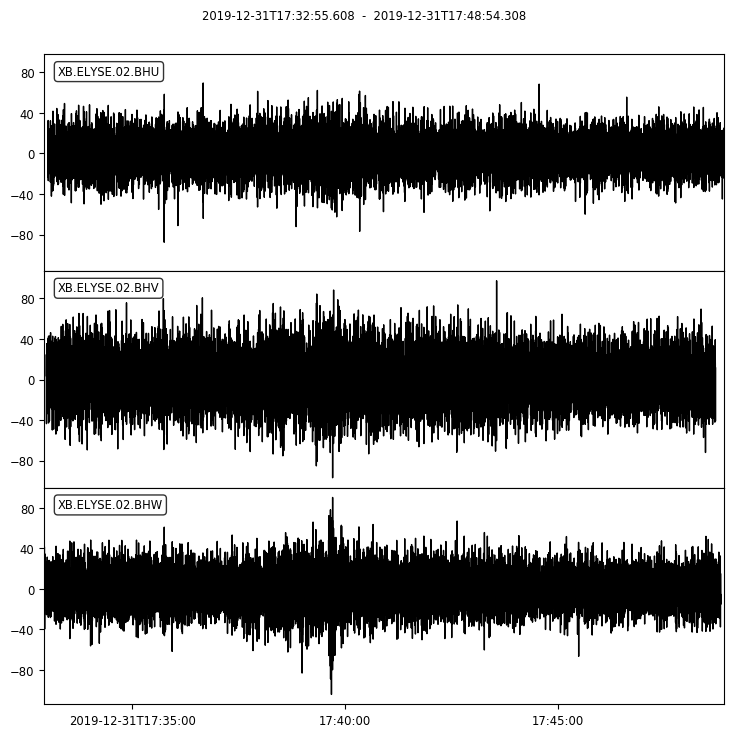

In [17]:
download_and_plot(event_samples[0])

downloading: XB-ELYSE-02-2019-08-22T07:08:07.121950Z-2019-08-22T07:23:21.894884Z.mseed
/home/b/.seisml/mars/events/XB-ELYSE-02-2019-08-22T07:08:07.121950Z-2019-08-22T07:23:21.894884Z.mseed


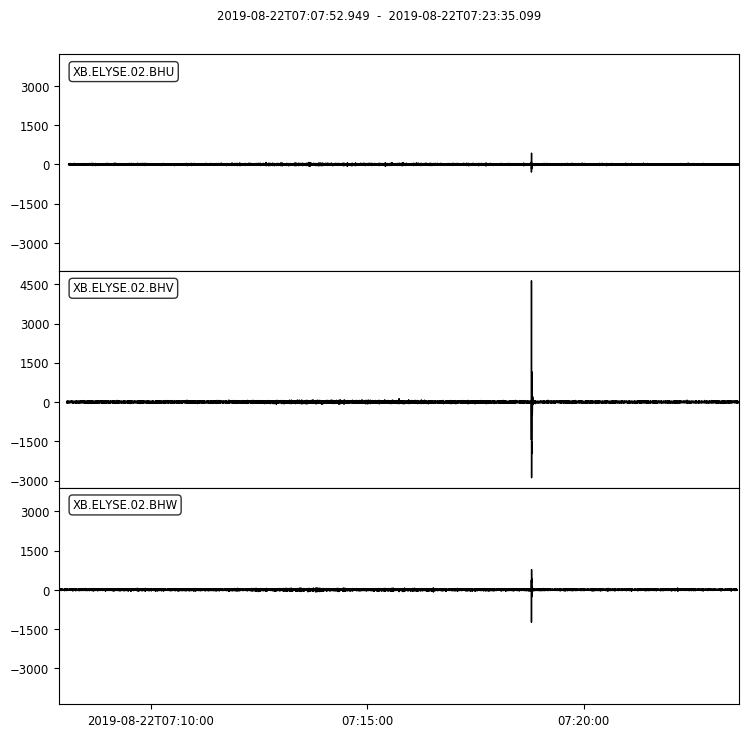

In [20]:
download_and_plot(list(filter(lambda x: x[0] == 'S0261b', event_samples))[0])